In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# Load the Cora dataset with SSL verification disabled
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [3]:
# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GraphSAGE(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [4]:
# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

Epoch 000, Loss: 1.9593
Epoch 020, Loss: 0.0643
Epoch 040, Loss: 0.0218
Epoch 060, Loss: 0.0084
Epoch 080, Loss: 0.0036
Epoch 100, Loss: 0.0102
Epoch 120, Loss: 0.0106
Epoch 140, Loss: 0.0051
Epoch 160, Loss: 0.0030
Epoch 180, Loss: 0.0079


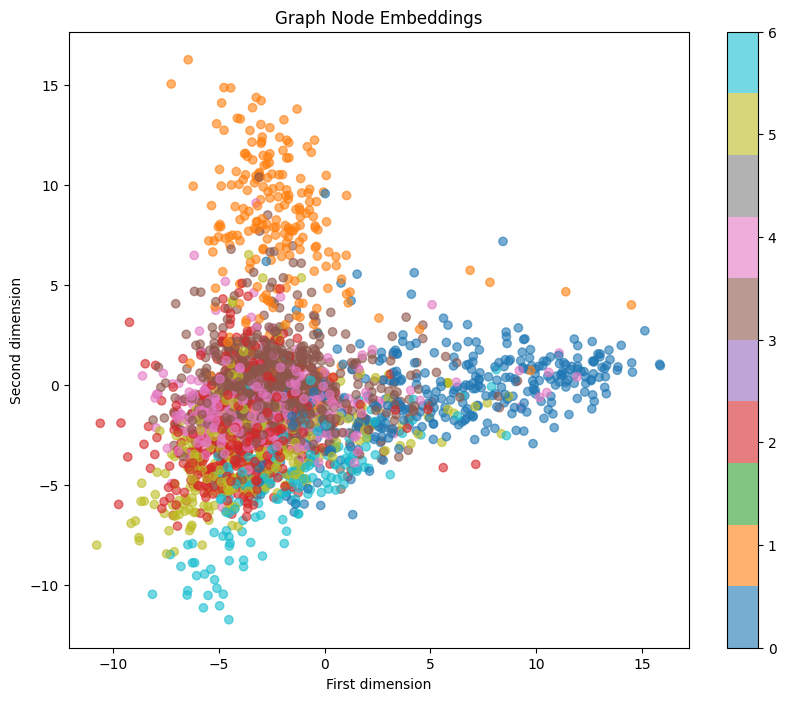

In [5]:
# Get embeddings
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)
    
# Convert embeddings to numpy for visualization
embeddings_np = embeddings.numpy()
labels_np = data.y.numpy()

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_np[:, 0], embeddings_np[:, 1], 
                     c=labels_np, cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('Graph Node Embeddings')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.show()